In [1]:
import requests
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from itertools import chain
# 'http://www.socialbrite.org/cause-organizations/'
# 'http://www.usgovernmentspending.com/breakdown2016_0.html'
# 'http://www.washingtonpost.com/blogs/wonkblog/wp/2015/03/17/the-mysterious-1-1-trillion-in-spending-cuts-in-the-house-gops-budget/
# 'http://www.thefiscaltimes.com/2015/03/23/House-Democrats-Push-Back-Against-GOP-Spending-Cuts'
import numpy as np
%matplotlib inline
plt.style.use('ggplot')
commons = ['a','aboard','about','above','absent','across','after','against','all','along',
           'alongside','amid','amidst','among','an','and','anti','around','as','at','atop',
           'backward','forward',
           'bar','barring','before','behind','below','beneath','beside','besides' ,'between',
           'beyond','but','by','circa','counting','concerning','considering','despite','down',
           'during','except','excepting','excluding','following','for','from','given','gone',
           'in','inside','instead','into','is','less','like','mid','minus','near','next','of',
           'off','on','onto','opposite','out','outside','over','past','pending','per','plus',
           'pro','regarding','regardless' ,'round','save','saving','since','than','that','the',
           'their','there','through','throughout','till','times','to','toward','towards',
           'under','underneath','unlike','until','up','upon','versus' ,'via','with','within',
           'without','worth','',' ','will','this','say','other']
bad = ['|','','/','\\',u'\u2014']

class wsite(object):
    def __init__(self, url):
        self.url = url
    
    def get_text(self, console='no'):
        agent = {
                'Firefox' : 'Mozilla/5.0', 
                'Explorer': 'Windows NT 6.1',
                'KHTML'   : 'AppleWebKit/537.36',
                'Chrome'  : 'Chrome/41.0.2228.0',
                'Safari'  : 'Safari/537.36'
                }
        a = True
        for i in agent.values(): 
            while a:
                p = requests.get(self.url, headers = {'User-Agent': i})
                print 'Status Code: ',p.status_code
                text = BeautifulSoup(p.text)
                if text.title.get_text() == 'Not Acceptable!':
                    continue
                else:
                    a = False
        self.text = text
        if console == 'yes':
            return text
    
    def cache(self, cache_file):
        # to work on offline. Note utf-8.
        with open(cache_file, 'w') as f:
            f.write(self.text.encode('utf-8'))
                    
    def pullSites(self, console='no'):
        # get full links, not internal links (start with #)
        # and don't count internal links (original)
        atext = self.text.find_all('a',href=re.compile('^[^#]'))
        self.atext = atext
        orig = re.search('www\.(.*)\.', self.url).group(1) 
        allsites=[]
        for i in range(len(atext)):
            if 'http' in atext[i].attrs['href']:
                if orig not in atext[i].attrs['href']:
                    allsites.append(atext[i].attrs['href'])
        self.allsites = allsites
        if console == 'yes':
            return allsites
    
    def removeDuplicates(self, console='no'):
        # remove duplicate links
        new = []
        for i in self.allsites:
            if i not in new:
                new.append(i)
        self.new = new
        if console == 'yes':
            return new
    
    def checkStatus(self, console='no'):
        # get status of url link and sort accordingly
        IL = [] # informational
        OK = [] # success
        RD = [] # re-directed
        CE = [] # client error
        SE = [] # server error
        broken = []
        for i in self.new:
            try:
                resp = requests.head(i)
                if resp.status_code >= 500:
                    SE.append(i)
                elif resp.status_code >= 400:
                    CE.append(i)
                elif resp.status_code >= 300:
                    RD.append(i)
                elif resp.status_code >= 200:
                    OK.append(i)
                elif resp.status_code >= 100:
                    IL.append(i)
            except:
                broken.append(i)
        urls = [IL, OK, RD, CE, SE, broken]
        self.urls = urls
        if console == 'yes':
            return urls
        # future: fix by putting into dictionary with names
    
    def plt_status_codes(self, fs=12, wh=0.35):
        hgh = map(lambda x: len(x), self.urls)
        ind = np.arange(len(self.urls))
        names = ['Info', 'Ok', 'Redirected', 'Client E', 'Server E', 'Broken']
        total = sum(hgh)
        percents = map(lambda x: round((float(x)/float(total))*100,1), hgh)
        
        fig = plt.figure(figsize=(7,7),dpi=600)
        plt.bar(ind,hgh)
        plt.ylabel('Count', fontsize = fs)
        plt.title('URL Status Codes',fontsize=fs+4)
        plt.xticks(ind+0.6/2,names,fontsize = fs)
        plt.text(4,max(hgh)/2,'Total Sites: '+str(total), fontsize=fs)
        for i in range(len(percents)):
            plt.text(i + 0.3, hgh[i] + 0.1, str(percents[i])+'%')
        plt.savefig('StatusCodes.pdf')
        
    def counting(self, console = 'no'):
        apdict = {i: i.find_next_sibling(text=True) for i in self.atext}
        counted = {}
        comb_list = list(chain(urls[1],urls[2]))
        for i,j in apdict.items():
            if i['href'] in comb_list and j != None:
                paragraph = {}
                for word in j.split():
                    word = word.strip('.,?!/|\\').lower()
                    if word in paragraph:
                        paragraph[word] += 1
                    else:
                        paragraph[word] = 1
                counted[i['href']] = paragraph
        if not any(counted.values()):
            print 'No associated paragraphs'
        else:
            self.counted = counted
        if console == 'yes':
            return counted
        
    def plt_words(self, numb = 5):
        allwords = {}
        wcount = 0 
        for i,j in self.counted.items():
            for k,l in j.items():
                wcount += l
                if k not in allwords:
                    allwords[k] = l
                else:
                    allwords[k] += l
        
        fig = plt.figure(figsize=(7,7),dpi=600)
        ind = np.arange(numb)
        for x in range(2):
            percents=[]
            if x == 0:
                for i,j in allwords.items():
                    plt.title('Top Real Words',fontsize=16)
                    figname = 'Top_Real.pdf'
                    if i not in commons and i not in bad:
                        percents.append((i,float(j)/wcount*100))
            elif x == 1:
                for i,j in allwords.items():
                    if i not in bad:
                        plt.title('Top Words',fontsize=16)
                        figname = 'Top_All.pdf'
                        percents.append((i,float(j)/wcount*100))
            
            allsorted = sorted(percents,key=lambda x: x[1],reverse=True)
            perc=[]
            name=[]
            for k in range(numb):
                perc.append(allsorted[k][1])
                name.append(allsorted[k][0])

            plt.xlabel('Total Words: '+str(wcount), fontsize=12)
            plt.bar(ind,perc)
            plt.ylabel('Percent', fontsize = 12)
            plt.xticks(ind+0.6/2,name,fontsize = 12, rotation=45)
            plt.savefig(figname)

In [7]:
s = wsite('http://www.thefiscaltimes.com/2015/03/23/House-Democrats-Push-Back-Against-GOP-Spending-Cuts')
s.get_text()
s.pullSites()
s.removeDuplicates()

Status Code:  200


In [8]:
%%time
urls = s.checkStatus('yes')

CPU times: user 72.8 ms, sys: 7.63 ms, total: 80.4 ms
Wall time: 3.98 s


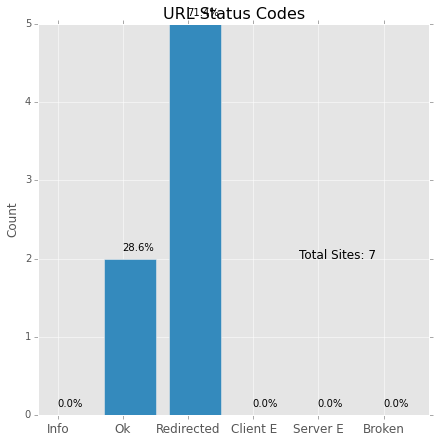

In [9]:
s.plt_status_codes()

In [10]:
counted = s.counting('yes')

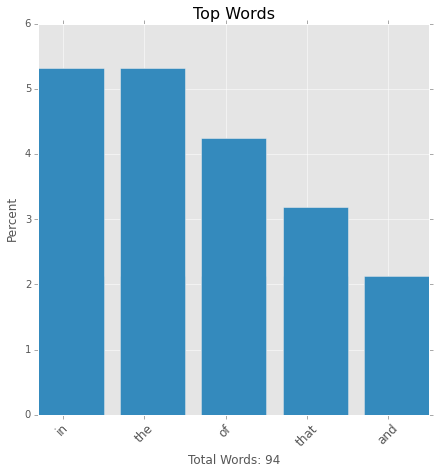

In [11]:
s.plt_words()

In [12]:
(3653*0.8)/100

29.224

In [14]:
(1.0/3653.0)*100.0

0.027374760470845878